# Deep Learning for Malaria Diagnosis

Malaria is an infectuous disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes.

The Malaria burden with some key figures:
<font color='red'>
* More than 219 million cases
* Over 430 000 deaths in 2017 (Mostly: children & pregnants)
* 80% in 15 countries of Africa & India
  </font>

![MalariaBurd](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaBurden.png?raw=1)

The malaria diagnosis is performed using blood test:
* Collect patient blood smear 
* Microscopic visualisation of the parasit

![MalariaDiag](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaDiag.png?raw=1)
  
Main issues related to traditional diagnosis: 
<font color='#ed7d31'>
* resource-constrained regions 
* time needed and delays
* diagnosis accuracy and cost
</font>

The objective of this notebook is to apply modern deep learning techniques to perform medical image analysis for malaria diagnosis.

*This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018), (Adrian Rosebrock, 2018) and (Jason Brownlee, 2019)*

## Configuration

* **Useful infos**: *https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d*

In [0]:
#Mount the local drive project_forder
from google.colab import drive
drive.mount('/content/drive/')
!ls "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/
cell_images.zip			       doc-images	    test
deep-learning4malaria-diagnosis.ipynb  physician_questions  train


In [0]:
# Use GPU: Please check if the outpout is '/device:GPU:0'
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

1.14.0


'/device:GPU:0'

## Populating namespaces

In [0]:
# Importing basic libraries
import os
import random
import shutil
from matplotlib import pyplot
from matplotlib.image import imread
%matplotlib inline

# Importing the Keras libraries and packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D as Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

In [0]:
# Define the useful paths for data accessibility
ai_project = '.' #"/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
cell_images_dir = os.path.join(ai_project,'cell_images')
training_path = os.path.join(ai_project,'train')
testing_path = os.path.join(ai_project,'test')

## Prepare DataSet

### *Download* DataSet

In [0]:
# Download the data in the allocated google cloud-server. If already down, turn downloadData=False
downloadData = True
if downloadData == True:
  indrive = False
  if indrive == True:
    !wget https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip -P "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
    !unzip "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/cell_images.zip" -d "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/"
    !ls "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
  else: #incloud google server
    !rm -rf cell_images.*
    !wget https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip
    !unzip cell_images.zip >/dev/null 2>&1
    !ls 

--2019-07-23 13:29:18--  https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip
Resolving ceb.nlm.nih.gov (ceb.nlm.nih.gov)... 130.14.52.15, 2607:f220:41e:7052::15
Connecting to ceb.nlm.nih.gov (ceb.nlm.nih.gov)|130.14.52.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M  19.2MB/s    in 17s     

2019-07-23 13:29:36 (20.1 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]

cell_images  cell_images.zip  sample_data


### Visualize cell images

13780 Uninfected images: view of 6 samples
(139, 133, 3)


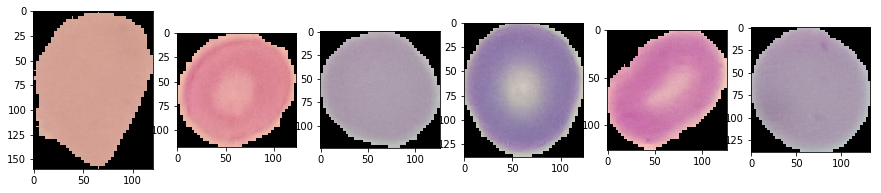

In [0]:
# Visualize some samples (randomly selected) of blood smears from healthy patients 
N_samples = 6
uninfected_dir = os.path.join(cell_images_dir,'Uninfected')
uninfected_samples = random.sample(os.listdir(uninfected_dir), N_samples)
pyplot.figure(figsize=(15,3))
print("{} Uninfected images: view of {} samples".format(len(os.listdir(uninfected_dir)), N_samples))
i = 0
while i < N_samples: # in random.sample(os.listdir(parasitized_dir), 6):
    pyplot.subplot(1,N_samples,1+i)
    img_uninfected = imread(os.path.join(uninfected_dir, uninfected_samples[i]))
    pyplot.imshow(img_uninfected)
    i+=1
print(img_uninfected.shape)

13780 Parasitized images: view of 6 samples
(121, 118, 3)


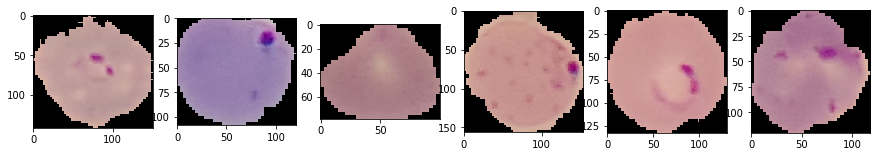

In [0]:
# Visualize some samples (randomly selected) of blood smears from patients falciparum-infected 
print("{} Parasitized images: view of {} samples".format(len(os.listdir(uninfected_dir)), N_samples))
parasitized_dir = os.path.join(cell_images_dir,'Parasitized')
parasitized_samples = random.sample(os.listdir(parasitized_dir), N_samples)
pyplot.figure(figsize=(15,3))
i = 0
while i < N_samples: # in random.sample(os.listdir(parasitized_dir), 6):
    pyplot.subplot(1,N_samples,1+i)
    img_parasitized = imread(os.path.join(parasitized_dir, parasitized_samples[i]))
    pyplot.imshow(img_parasitized)
    i+=1
print(img_parasitized.shape)

### Split train-test

In [0]:
def create_train_test_data(class_name, train_split = 0.8):
    '''
      #Create a function create_train_test_data to split data into 
      #training and testing sets with respectives proportion 80%, 20%
      #--Train (@training_path)
          #--Parasitized
          #--Uninfected
      #--Test (@training_path)
          #--Parasitized
          #--Uninfected
      @class_name: 'Parasitized' or 'Uninfected'
      @train_split: eg. 80% train 20% test
    '''
    #Not Implemented
    
    train_class_path = os.path.join(training_path,class_name)  
    test_class_path = os.path.join(testing_path,class_name)

    class_img_names = [img for img in os.listdir(os.path.join(cell_images_dir, class_name))]
    random.seed(42)
    random.shuffle(class_img_names)

    # compute the training and testing split
    i = int(len(class_img_names) * train_split)
    train_class_img_names = class_img_names[:i]
    test_class_img_names = class_img_names[i:]

    def copy_imgs(learn_class_img_names, learn_class_path):
        if not os.path.exists(learn_class_path):
            os.makedirs(learn_class_path)
        for img in learn_class_img_names:
            p_orig = os.path.join(cell_images_dir,class_name,img) 
            p_dest = os.path.join(learn_class_path,img) 
            shutil.copy2(p_orig, p_dest)

    copy_imgs(train_class_img_names, train_class_path)
    copy_imgs(test_class_img_names, test_class_path)

SplitTrainTest = True
if SplitTrainTest == True:
    if os.path.exists(training_path): shutil.rmtree(training_path)
    if os.path.exists(testing_path): shutil.rmtree(testing_path)
    create_train_test_data('Parasitized')
    create_train_test_data('Uninfected')

## Baseline CNN Model
Define a basic ConvNet defined with ConvLayer: Conv2D => MaxPooling2D followed by Flatten => Dense => Dense(output)

![ConvNet](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/ConvNet.png?raw=1)


In [0]:
#single convolutional layer with 32 filters followed by a max pooling layer.
from keras.preprocessing.image import ImageDataGenerator
BatchSize = 32
xy_shape = 64
n_epochs = 20

Using TensorFlow backend.


In [0]:
# define cnn model
def simple_cnn_model():
    model = Sequential()
    # 1 ConvLayer
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(xy_shape, xy_shape, 3)))
    model.add(MaxPooling2D((2, 2)))
    # Flatten and Dense layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    #opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [0]:
# Instanciate a data generator to fit the model
dataGen = ImageDataGenerator(rescale=1.0/255.0)
# prepare iterators
train_gen = dataGen.flow_from_directory(training_path,class_mode="binary",target_size=(xy_shape, xy_shape),
                                         batch_size=BatchSize)
test_gen = dataGen.flow_from_directory(testing_path,class_mode="binary",target_size=(xy_shape, xy_shape),
                                        batch_size=BatchSize)

Found 22046 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


In [0]:
# Instanciate and train the model
conv_net1 = simple_cnn_model()
conv_net1_loss_acc_records = conv_net1.fit_generator(train_gen, steps_per_epoch=len(train_gen),validation_data=test_gen, validation_steps=len(test_gen), 
                              epochs=n_epochs, verbose=1, use_multiprocessing=True)#, workers=) #validation_freq=[1,2,5,10,15,20],

W0723 13:39:04.388783 140433547532160 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0723 13:39:04.449588 140433547532160 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
689/689 [==============================] - 38s 56ms/step - loss: 0.7165 - acc: 0.6470 - val_loss: 0.5646 - val_acc: 0.7152
Epoch 2/20
689/689 [==============================] - 34s 50ms/step - loss: 0.5274 - acc: 0.7401 - val_loss: 0.5168 - val_acc: 0.7378
Epoch 3/20
689/689 [==============================] - 34s 50ms/step - loss: 0.4551 - acc: 0.7864 - val_loss: 0.4897 - val_acc: 0.7560
Epoch 4/20
689/689 [==============================] - 34s 50ms/step - loss: 0.3611 - acc: 0.8414 - val_loss: 0.4285 - val_acc: 0.8075
Epoch 5/20
689/689 [==============================] - 35s 50ms/step - loss: 0.2494 - acc: 0.9037 - val_loss: 0.3886 - val_acc: 0.8302
Epoch 6/20
689/689 [==============================] - 34s 50ms/step - loss: 0.1638 - acc: 0.9410 - val_loss: 0.3787 - val_acc: 0.8534
Epoch 7/20
689/689 [==============================] - 34s 50ms/step - loss: 0.1059 - acc: 0.9628 - val_loss: 0.3687 - val_acc: 0.8612
Epoch 8/20
689/689 [==============================] - 34s 50ms

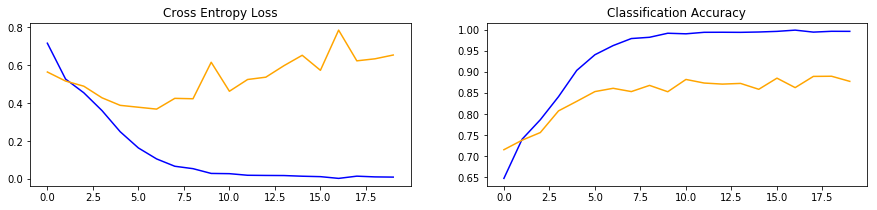

In [0]:
# This function is defined to visualise loss and accuracy
def assess_performance(history):
    pyplot.figure(figsize=(15,3))
    # plot loss
    pyplot.subplot(121)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(122)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['acc'], color='blue', label='train')
    pyplot.plot(history.history['val_acc'], color='orange', label='test')

assess_performance(conv_net1_loss_acc_records)

In [0]:
# evaluate model
_, acc = conv_net1.evaluate_generator(test_gen, steps=len(test_gen), use_multiprocessing=True, verbose=0)
print('> %.3f' % (acc * 100.0))

> 87.772


### Data Augmentation

In [0]:
# Use data augmentation techniques to generate more variational data and improve the performance
# data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset.
# Training deep learning neural network models on more data can result in more skillful models, and the augmentation techniques can create variations of the images that can improve the ability of the fit models to generalize what they have learned to new images.
# the training dataset will be augmented with small (10%) random horizontal and vertical shifts and random horizontal flips that create a mirror image of a photo. Photos in both the train and test steps will have their pixel values scaled in the same way.

trainAug = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode="nearest")
train_aug = trainAug.flow_from_directory(training_path,class_mode="binary",target_size=(xy_shape, xy_shape),
                                         batch_size=BatchSize)
# Keep
dataGen = ImageDataGenerator(rescale=1.0/255.0)

# test_gen = None
# test_gen = <TODO>
test_gen = dataGen.flow_from_directory(testing_path,class_mode="binary",target_size=(xy_shape, xy_shape),
                                        batch_size=BatchSize)

Found 22046 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


In [0]:
# Train the model with augmented data and assess the performance
conv_net1_aug = simple_cnn_model()
conv_net1_aug_loss_acc_records = conv_net1_aug.fit_generator(train_aug, steps_per_epoch=len(train_aug),validation_data=test_gen, validation_steps=len(test_gen), 
                              epochs=n_epochs, verbose=1, use_multiprocessing=True, workers=2) #validation_freq=[1,2,5,10,15,20],

Epoch 1/20
689/689 [==============================] - 53s 77ms/step - loss: 0.6913 - acc: 0.6465 - val_loss: 0.6492 - val_acc: 0.6304
Epoch 2/20
689/689 [==============================] - 53s 76ms/step - loss: 0.5802 - acc: 0.6975 - val_loss: 0.5656 - val_acc: 0.7014
Epoch 3/20
689/689 [==============================] - 52s 76ms/step - loss: 0.5293 - acc: 0.7405 - val_loss: 0.4653 - val_acc: 0.7763
Epoch 4/20
689/689 [==============================] - 52s 76ms/step - loss: 0.4452 - acc: 0.7953 - val_loss: 0.4221 - val_acc: 0.8258
Epoch 5/20
689/689 [==============================] - 52s 76ms/step - loss: 0.3509 - acc: 0.8533 - val_loss: 0.3455 - val_acc: 0.8725
Epoch 6/20
689/689 [==============================] - 52s 76ms/step - loss: 0.2736 - acc: 0.8946 - val_loss: 0.2536 - val_acc: 0.9008
Epoch 7/20
689/689 [==============================] - 53s 76ms/step - loss: 0.2355 - acc: 0.9106 - val_loss: 0.2619 - val_acc: 0.9064
Epoch 8/20
689/689 [==============================] - 52s 76ms

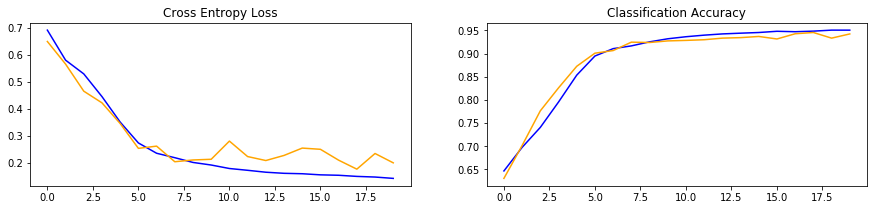

In [0]:
# Plot loss and accurate and conclude
assess_performance(conv_net1_aug_loss_acc_records)

In [0]:
# evaluate model
_, acc = conv_net1_aug.evaluate_generator(test_gen, steps=len(test_gen), use_multiprocessing=True, verbose=0)
print('> %.3f' % (acc * 100.0))

> 94.231


## 2-ConvLayers CNN

* Add a second ConvLayer to the simple_cnn

In [0]:
def cnn_model():
    '''
      Create the 2 layers ConvNet: FirstConvLayer > FirstConvLayer > Flatten > Dense > Dense(output)
    '''
    # Not Implemmented
    model = Sequential()
    # First ConvLayer
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(xy_shape, xy_shape, 3)))
    model.add(MaxPooling2D((2, 2)))
    # Second ConvLayer
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    # Flatten & Dense Layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    #opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [0]:
conv_net2_aug = cnn_model()
conv_net2_aug_loss_acc_records = conv_net2_aug.fit_generator(train_aug, steps_per_epoch=len(train_aug),validation_data=test_gen, validation_steps=len(test_gen), 
                              epochs=n_epochs, verbose=1, use_multiprocessing=True, workers=2) #validation_freq=[1,2,5,10,15,20],

Epoch 1/20
689/689 [==============================] - 54s 78ms/step - loss: 0.6172 - acc: 0.6574 - val_loss: 0.3190 - val_acc: 0.8735
Epoch 2/20
689/689 [==============================] - 53s 77ms/step - loss: 0.2483 - acc: 0.9089 - val_loss: 0.2567 - val_acc: 0.9124
Epoch 3/20
689/689 [==============================] - 53s 77ms/step - loss: 0.1852 - acc: 0.9385 - val_loss: 0.1730 - val_acc: 0.9478
Epoch 4/20
689/689 [==============================] - 53s 77ms/step - loss: 0.1727 - acc: 0.9444 - val_loss: 0.1613 - val_acc: 0.9474
Epoch 5/20
689/689 [==============================] - 53s 76ms/step - loss: 0.1608 - acc: 0.9490 - val_loss: 0.1722 - val_acc: 0.9519
Epoch 6/20
689/689 [==============================] - 52s 76ms/step - loss: 0.1513 - acc: 0.9516 - val_loss: 0.1616 - val_acc: 0.9487
Epoch 7/20
689/689 [==============================] - 52s 76ms/step - loss: 0.1483 - acc: 0.9520 - val_loss: 0.1572 - val_acc: 0.9470
Epoch 8/20
689/689 [==============================] - 53s 77ms

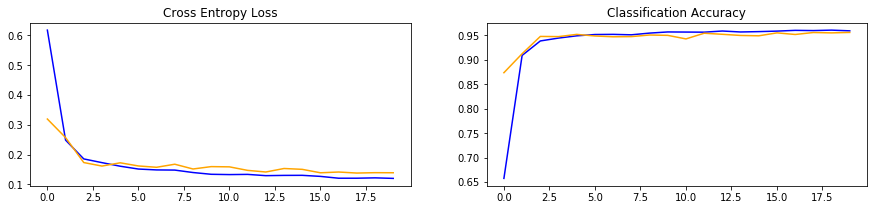

In [0]:
assess_performance(conv_net2_aug_loss_acc_records)

In [0]:
from keras.models import load_model
#model2_aug.save('second_model-aug_20e.h5')
#model2_aug = load_model('second_model-aug_20e.h5')
# evaluate model
_, acc = conv_net2_aug.evaluate_generator(test_gen, steps=len(test_gen), use_multiprocessing=True, verbose=0)
print('> %.3f' % (acc * 100.0))

> 95.591


## Transfer Learning

In [0]:
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
# define cnn model
xy_shape3 = 224
BatchSize3 = 64
def deep_cnn_transfer_model():
    #<TODO>: after the 
    model = VGG16(include_top=False, input_shape=(xy_shape3, xy_shape3, 3))
    # mark loaded layers as not trainable
    nb_layers = len(model.layers)
    print('nb_layers:',nb_layers)
    for layer in model.layers: #[:nb_layers-5]:  #model.layers[1:20]
        layer.trainable=False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(1, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    #opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [0]:
conv_deep_transfer = deep_cnn_transfer_model()
conv_deep_transfer.summary()

In [0]:
train_aug = trainAug.flow_from_directory(training_path,class_mode="binary",target_size=(xy_shape3, xy_shape3),
                                         batch_size=BatchSize3)
test_gen = dataGen.flow_from_directory(testing_path,class_mode="binary",target_size=(xy_shape3, xy_shape3),
                                        batch_size=BatchSize3)

Found 22046 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


In [0]:
conv_deep_transfer_loss_acc_records = conv_deep_transfer.fit_generator(train_aug, steps_per_epoch=len(train_aug),validation_data=test_gen, validation_steps=len(test_gen), 
                              epochs=n_epochs, verbose=1, use_multiprocessing=True, workers=2) #validation_freq=[1,2,5,10,15,20],

Epoch 1/20
345/345 [==============================] - 316s 917ms/step - loss: 0.3448 - acc: 0.8675 - val_loss: 0.3803 - val_acc: 0.8197
Epoch 2/20
345/345 [==============================] - 305s 883ms/step - loss: 0.2319 - acc: 0.9088 - val_loss: 0.1933 - val_acc: 0.9260
Epoch 3/20
345/345 [==============================] - 307s 889ms/step - loss: 0.2147 - acc: 0.9159 - val_loss: 0.1890 - val_acc: 0.9220
Epoch 4/20
345/345 [==============================] - 305s 884ms/step - loss: 0.1860 - acc: 0.9277 - val_loss: 0.2396 - val_acc: 0.9071
Epoch 5/20
345/345 [==============================] - 306s 888ms/step - loss: 0.1870 - acc: 0.9291 - val_loss: 0.1812 - val_acc: 0.9274
Epoch 6/20
345/345 [==============================] - 307s 889ms/step - loss: 0.1765 - acc: 0.9321 - val_loss: 0.1849 - val_acc: 0.9263
Epoch 7/20
345/345 [==============================] - 304s 882ms/step - loss: 0.1724 - acc: 0.9333 - val_loss: 0.2099 - val_acc: 0.9187
Epoch 8/20
345/345 [============================

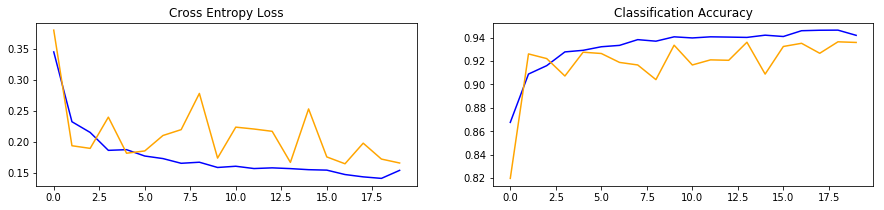

In [0]:
assess_performance(conv_deep_transfer_loss_acc_records)

In [0]:
#model3.save('vgg16_model_20e.h5')
# evaluate model
_, acc = conv_deep_transfer.evaluate_generator(test_gen, steps=len(test_gen), use_multiprocessing=True, verbose=0)
print('> %.3f' % (acc * 100.0))

> 93.578


## Compare performance results

*   conv_net1: 
*   conv_net1_aug
*   conv_net2_aug:
*   conv_deep_transfer:

***Conclusion:***

## Prediction: Automatic AI-based malaria diagnosis

In [0]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
# load and prepare the image
def load_image(filename, xy_shape=xy_shape):
    # load the image
    img = load_img(filename, target_size=(xy_shape, xy_shape))
    pyplot.imshow(img)
    # convert to array
    img = img_to_array(img)
    #print(img)
    # reshape into a single sample with 3 channels
    img = img.reshape(1, xy_shape, xy_shape, 3)
    # center pixel data
    img = img.astype('float32')/255
    #img = img - [123.68, 116.779, 103.939]
    return img

Prediction: 0.03% => Parasitized


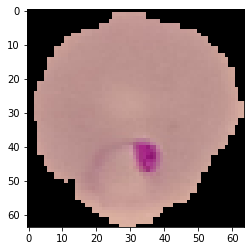

In [0]:
#!cp /content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/physician_questions/patient_1.png .
!wget https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/physician_questions/patient_1.png
p_ask_image = 'patient_1.png' #os.path.join('physician_questions', 'patient_4.png')
image = load_image(p_ask_image)
pred_prod = model2.predict(image)[0][0]
print('Prediction: {:.2%} => {}'.format(pred_prod, 'Uninfected' if pred_prod > 0.5 else 'Parasitized'))